In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import git

In [2]:
# variables and files to be apply zonal averaging to
zon_avg_metadata_list = [
    {'varnames':['thetao'],
     'fname_in':'../omip1/thetao_Oyr_CESM2_omip1_r2i1p1f1_gr_0311-0372.nc',
     'fname_out':'../omip1/thetao_Oyr_CESM2_omip1_r2i1p1f1_gr_zon_avg_0311-0372.nc'},
    {'varnames':['thetao'],
     'fname_in':'../omip2/thetao_Oyr_CESM2_omip2_r1i1p1f1_gr_0306-0366.nc',
     'fname_out':'../omip2/thetao_Oyr_CESM2_omip2_r1i1p1f1_gr_zon_avg_0306-0366.nc'},
    {'varnames':['so'],
     'fname_in':'../omip1/so_Oyr_CESM2_omip1_r2i1p1f1_gr_0311-0372.nc',
     'fname_out':'../omip1/so_Oyr_CESM2_omip1_r2i1p1f1_gr_zon_avg_0311-0372.nc'},
    {'varnames':['so'],
     'fname_in':'../omip2/so_Oyr_CESM2_omip2_r1i1p1f1_gr_0306-0366.nc',
     'fname_out':'../omip2/so_Oyr_CESM2_omip2_r1i1p1f1_gr_zon_avg_0306-0366.nc'},
]

In [3]:
# construct omip_basin_mask
fname_1x1 = 'ocean_remap_1x1.REGION_MASK.nc'
ds_1x1 = xr.open_dataset(fname_1x1)

omip_basin_names = ['global_ocean', 'atlantic_arctic_ocean', 'indian_ocean', 'pacific_ocean']
omip_basin_names_concat = ', '.join([f'{basin_name}={basin_ind}' for basin_ind, basin_name in enumerate(omip_basin_names)])
basin_cnt = len(omip_basin_names)
basin_indices = np.arange(basin_cnt)
basin_coord = xr.DataArray(basin_indices, dims=('basin'))
basin_coord.encoding['dtype'] = 'int32'
basin_coord.attrs = {'title':'ocean basin', 'standard_name':'region', 'requested':omip_basin_names_concat}
omip_basin_mask = xr.DataArray(
    np.zeros((basin_cnt, ds_1x1.dims['lat'], ds_1x1.dims['lon'])),
    dims=('basin', 'lat', 'lon'),
    coords={'basin':basin_coord, 'lat':ds_1x1.lat, 'lon':ds_1x1.lon})
omip_basin_mask[0,:,:] = np.where(ds_1x1.REGION_MASK.notnull(), 1.0, 0.0)
omip_basin_mask[1,:,:] = np.where((ds_1x1.REGION_MASK.round()==6)
                                  | ((ds_1x1.REGION_MASK.round()==7) & (ds_1x1.lat>=46.0))
                                  | (ds_1x1.REGION_MASK.round()==8)
                                  | (ds_1x1.REGION_MASK.round()==9)
                                  | (ds_1x1.REGION_MASK.round()==10)
                                  | ((ds_1x1.REGION_MASK.round()==1)
                                     & ((ds_1x1.lon>=293.0)
                                        | ((ds_1x1.lon>=291.0) & (ds_1x1.lat>=-54.0))
                                        | (ds_1x1.lon<20.0))), 1.0, 0.0)
omip_basin_mask[2,:,:] = np.where((ds_1x1.REGION_MASK.round()==3)
                                  | (ds_1x1.REGION_MASK.round()==4)
                                  | ((ds_1x1.REGION_MASK.round()==1)
                                     & ((ds_1x1.lon>=20.0) & (ds_1x1.lon<147.0))), 1.0, 0.0)
omip_basin_mask[3,:,:] = np.where((ds_1x1.REGION_MASK.round()==2)
                                  | ((ds_1x1.REGION_MASK.round()==1)
                                     & ((ds_1x1.lon>=147.0)
                                        & (((ds_1x1.lon<293.0) & (ds_1x1.lat<-54.0))
                                          | (ds_1x1.lon<291.0)))), 1.0, 0.0)
# corrections to Bering Strait
omip_basin_mask[1,:,:] = np.where((ds_1x1.REGION_MASK>0)
                                  & (ds_1x1.lon>=180.0) & (ds_1x1.lon<200.0)
                                  & (ds_1x1.lat>=66.0) & (ds_1x1.lat<70.0),
                                  1.0, omip_basin_mask[1,:,:])
omip_basin_mask[2,:,:] = np.where((ds_1x1.REGION_MASK>0)
                                  & (ds_1x1.lon>=180.0) & (ds_1x1.lon<200.0)
                                  & (ds_1x1.lat>=60.0) & (ds_1x1.lat<70.0),
                                  0.0, omip_basin_mask[2,:,:])
omip_basin_mask[3,:,:] = np.where((ds_1x1.REGION_MASK>0)
                                  & (ds_1x1.lon>=180.0) & (ds_1x1.lon<200.0)
                                  & (ds_1x1.lat>=60.0) & (ds_1x1.lat<66.0),
                                  1.0, omip_basin_mask[3,:,:])

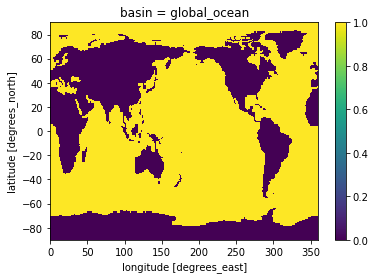

In [4]:
lon_slice=slice(0.0, 360.0)
lat_slice=slice(-90, 90.0)
omip_basin_mask.sel(basin=0).sel(lon=lon_slice, lat=lat_slice).plot();
plt.title('basin = '+omip_basin_names[0]);

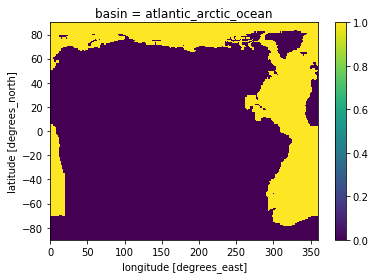

In [5]:
omip_basin_mask.sel(basin=1).sel(lon=lon_slice, lat=lat_slice).plot();
plt.title('basin = '+omip_basin_names[1]);

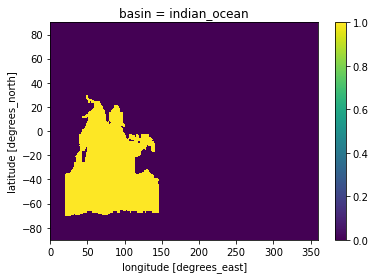

In [6]:
omip_basin_mask.sel(basin=2).sel(lon=lon_slice, lat=lat_slice).plot();
plt.title('basin = '+omip_basin_names[2]);

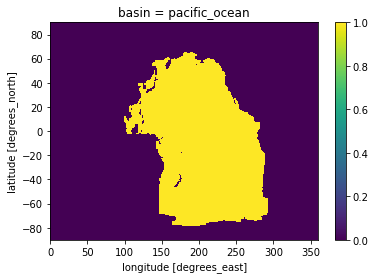

In [7]:
omip_basin_mask.sel(basin=3).sel(lon=lon_slice, lat=lat_slice).plot();
plt.title('basin = '+omip_basin_names[3]);

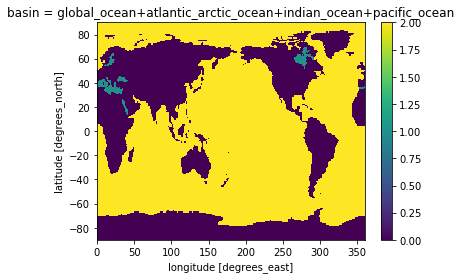

In [8]:
omip_basin_mask.isel(basin=slice(0, basin_cnt)).sum(dim='basin').sel(lon=lon_slice, lat=lat_slice).plot();
plt.title('basin = '+'+'.join(omip_basin_names[slice(0, basin_cnt)]));

In [9]:
for zon_avg_metadata in zon_avg_metadata_list:
    ds_in = xr.open_dataset(zon_avg_metadata['fname_in'], chunks={'time':1, 'lev':10})
    ds_out = xr.Dataset()
    for varname in zon_avg_metadata['varnames']:
        da_in = ds_in[varname]
        da_out = (omip_basin_mask * da_in).transpose('time', 'basin', 'lev', 'lat', 'lon').sum(dim='lon')
        ones_masked = xr.ones_like(da_in).where(da_in.notnull())
        denom = (omip_basin_mask * ones_masked).transpose('time', 'basin', 'lev', 'lat', 'lon').sum(dim='lon')
        da_out /= denom
        da_out.attrs = da_in.attrs

        # delete some attributes that do not make sense for zonal means
        for attr_name in ['cell_measures', 'cell_methods', 'comment']:
            del da_out.attrs[attr_name]

        # propagate some encoding info from da_in
        for key in ['dtype', '_FillValue', 'zlib', 'complevel']:
            if key in da_in.encoding:
                da_out.encoding[key] = da_in.encoding[key]
        if 'missing_value' in da_in.encoding:
            da_out.attrs['missing_value'] = np.float32(da_in.encoding['missing_value'])

        ds_out[varname] = da_out

    # if any variable in ds_out has a bounds attribute, copy the bounds variable over
    for varname in ds_out.variables:
        if 'bounds' in ds_out[varname].attrs:
            bounds_name = ds_out[varname].attrs['bounds']
            ds_out[bounds_name] = ds_in[bounds_name]

    # if a variable doesn't have _FillValue in the encoding, set _FillValue to None
    for varname in ds_out.variables:
        if '_FillValue' not in ds_out[varname].encoding:
            ds_out[varname].encoding['_FillValue'] = None

    ds_out.attrs = ds_in.attrs
    ds_out.attrs['contact'] = 'klindsay@ucar.edu'
    ds_out.attrs['githash'] = git.Repo(search_parent_directories=True).head.object.hexsha

    ds_out.to_netcdf(zon_avg_metadata['fname_out'], unlimited_dims='time')

/glade/work/klindsay/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/glade/work/klindsay/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/glade/work/klindsay/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/glade/work/klindsay/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
